#### Import modules & prepare data

In [2]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Import other modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from os import walk
from time import sleep
from IPython.display import clear_output
%matplotlib inline

# Data source: https://www.kaggle.com/stephenmugisha/particle-collisions

_, _, files = next(walk('data'))

target_names = {
    '0': 'electron',    # Negatively charged particle that is a lepton  (doesn't take part in strong force).
    '1': 'muon',    # Electron with 200 times more mass and makes up lots of cosmic radiation.
    '2': 'pion',    # Meson (connects with strong force) that can be positive, negative, or neutral
    '3': 'kaon',    # Pion with more mass.
    '4': 'proton'    # Positively charged particle with 2 up quarks and 1 down quark.
}

# Check how the data is formatted/stored.
file_test = open(f'data/{files[0]}', 'rb')
file = pickle.load(file_test)

print(file[0].shape)    # Group of 3000 images.
print(file[0][0].shape)    # Check first image.
print(file[1].shape)    # Group of 3000 targets.
print(file[1][0])    # Classified as 'pion.'

# Collect all the data.
data = []
target = []

for file in files:
    file = open(f'data/{files[0]}', 'rb')
    file =  pickle.load(file)

    for sample, sample_target in zip(file[0], file[1]):
        data.append(sample)
        target.append(sample_target)

data = np.array(data)
target = np.array(target)

sleep(7)
clear_output()

print(f'original data.shape: {data.shape}')
print(f'original target.shape: {target.shape}\n')

# Edit target values to 0, 1, 2...
new_target = []

for tar in target:
    if tar == 11:
        new_target.append(0)
    elif tar == 13:
        new_target.append(1)
    elif tar == 211:
        new_target.append(2)
    elif tar == 321:
        new_target.append(3)
    else:
        new_target.append(4)
    
target = np.array(new_target)

for i in range(5):
    particle_indexes = np.where(target == i)[0]

    data_modified = data[particle_indexes]
    target_modified = target[particle_indexes]
    
    print(f'{target_names[str(i)]}.shape: {data_modified.shape}, {target_modified.shape}')

# NOTE: through the above code, we find there are inconsistencies in the data (less samples for one particle but lots of samples in another)


original data.shape: (1259300, 10, 10)
original target.shape: (1259300,)

electron.shape: (3150, 10, 10), (3150,)
muon.shape: (700, 10, 10), (700,)
pion.shape: (981050, 10, 10), (981050,)
kaon.shape: (160300, 10, 10), (160300,)
proton.shape: (114100, 10, 10), (114100,)


#### Reshaping data (to make even)

In [3]:
muon_indexes = np.where(target == 1)[0]    # since this has least # of samples... use this as limiter

def set_data_samples(number_of_samples):    # limit to <= 700 samples for each particle. (to keep data even)
    
    data_new, target_new = ((data[muon_indexes])[:number_of_samples], (target[muon_indexes])[:number_of_samples])
    
    for i in [0, 2, 3, 4]:
        particle_indexes = np.where(target == i)[0]
        data_modified = (data[particle_indexes])[:number_of_samples]    
        target_modified = (target[particle_indexes])[:number_of_samples]
    
        data_new = np.append(data_new, data_modified, axis=0)
        target_new = np.append(target_new, target_modified)

    return (np.array(data_new), np.array(target_new))


data_50_samples, target_50_samples = set_data_samples(50)
data_100_samples, target_100_samples = set_data_samples(100)
data_150_samples, target_150_samples = set_data_samples(150)
data_200_samples, target_200_samples = set_data_samples(200)
data_250_samples, target_250_samples = set_data_samples(250)
data_300_samples, target_300_samples = set_data_samples(300)
data_350_samples, target_350_samples = set_data_samples(350)
data_400_samples, target_400_samples = set_data_samples(400)
data_450_samples, target_450_samples = set_data_samples(450)
data_500_samples, target_500_samples = set_data_samples(500)
data_550_samples, target_550_samples = set_data_samples(550)
data_600_samples, target_600_samples = set_data_samples(600)
data_650_samples, target_650_samples = set_data_samples(650)
data_700_samples, target_700_samples = set_data_samples(700)


# data_140_samples, target_140_samples = set_data_samples(140)    # NOTE: These will be used for later tests.
# data_280_samples, target_280_samples = set_data_samples(280)
# data_420_samples, target_420_samples = set_data_samples(420)
# data_560_samples, target_560_samples = set_data_samples(560)
# data_700_samples, target_700_samples = set_data_samples(700)

data = data_700_samples    # Regular number of samples that should be used.
target = target_700_samples

data_sklearn = data.reshape((3500, -1))

print(f'even data.shape: {data.shape}')
print(f'even target.shape: {target.shape}')

print(f'even data.shape (sklearn version): {data_sklearn.shape}')


even data.shape: (3500, 10, 10)
even target.shape: (3500,)
even data.shape (sklearn version): (3500, 100)


#### Data analysis

X_train.shape: (2625, 10, 10, 1)
y_train.shape: (2625, 5)
X_test.shape: (875, 10, 10, 1)
y_test.shape: (875, 5)

sklearn versions
X_train.shape: (2625, 100)
y_train.shape: (2625,)
X_test.shape: (875, 100)
y_test.shape: (875,)


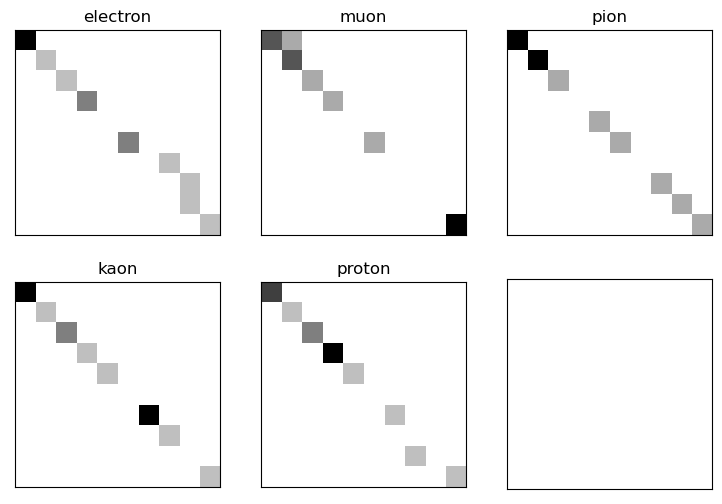

In [4]:
# Check for NaN values.
print(np.isnan(np.sum(data)))    # -> False

# Check range of values.
print(np.max(data), np.min(data))    # -> 8, 0

sleep(4)
clear_output()

# Get indexes for each different target possibility.
indexes = [
    np.where(target == 0)[0][0],
    np.where(target == 1)[0][0],
    np.where(target == 2)[0][0],
    np.where(target == 3)[0][0],
    np.where(target == 4)[0][0],
]

samples = [data[index] for index in indexes]
samples_target = [target_names[str(target[index])] for index in indexes]

fig, axs = plt.subplots(2, 3, figsize=(9, 6), subplot_kw={
    'yticks': (),
    'xticks': ()
})

axs = [ax for ax in axs.flatten()]

for sample, sample_target, ax in zip(samples, samples_target, axs):
    ax.imshow(sample, cmap='binary')
    ax.set_title(str(sample_target))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale and reshape data back to og form.
X_train = (scaler.fit_transform(X_train)).reshape((X_train.shape[0], 10, 10, 1))
X_test = (scaler.transform(X_test)).reshape((X_test.shape[0], 10, 10, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(data_sklearn, target, stratify=target)

y_train_sklearn, y_test_sklearn = ([], [])

for label in list(y_train):
    y_train_sklearn.append(list(label).index(1))    # changing sample from [0, 1, 0, 0, 0] to [2, .....]

for label in list(y_test):
    y_test_sklearn.append(list(label).index(1))

y_train_sklearn = np.array(y_train_sklearn)
y_test_sklearn = np.array(y_test_sklearn)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

print('\nsklearn versions')
print(f'X_train.shape: {X_train_sklearn.shape}')
print(f'y_train.shape: {y_train_sklearn.shape}')
print(f'X_test.shape: {X_test_sklearn.shape}')
print(f'y_test.shape: {y_test_sklearn.shape}')


#### Create TensorFlow Model

Epoch 1/3
42/42 [==============================] - 1s 2ms/step - loss: 2.0855 - accuracy: 0.2526
Epoch 2/3
42/42 [==============================] - 0s 2ms/step - loss: 1.9875 - accuracy: 0.2549
Epoch 3/3
42/42 [==============================] - 0s 2ms/step - loss: 1.9359 - accuracy: 0.2701
Train accuracy: 27.7%
Test accuracy: 23.2%


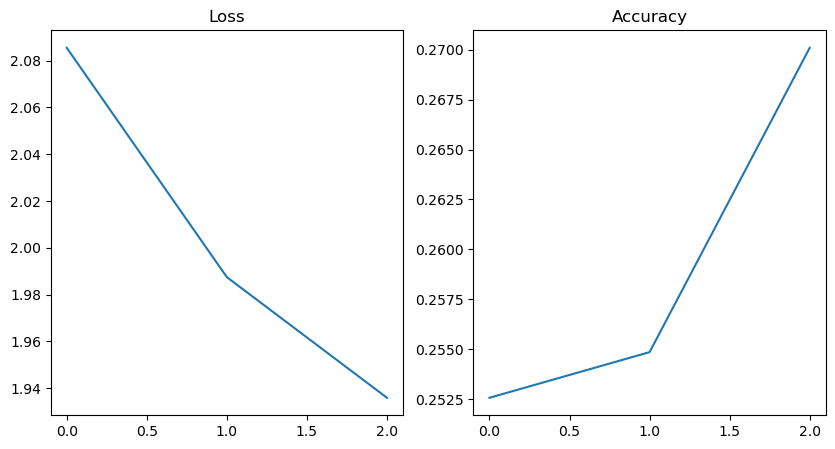

In [5]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(5, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

tf_model = Model()

tf_model.build(input_shape=(1, 10, 10, 1))
tf_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = tf_model.fit(X_train, y_train, epochs=3, batch_size=64).history

sleep(4)
# clear_output()

print(f'Train accuracy: {tf_model.evaluate(X_train, y_train, verbose=False)[1]*100:.1f}%')
print(f'Test accuracy: {tf_model.evaluate(X_test, y_test, verbose=False)[1]*100:.1f}%')

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5))

ax_1.plot(range(3), history['loss'])
ax_2.plot(range(3), history['accuracy'])

ax_1.set_title('Loss')
ax_2.set_title('Accuracy');


#### Create `sklearn` Model

In [6]:
logreg = LogisticRegression()

logreg.fit(X_train_sklearn, y_train_sklearn)

print(f'Train Accuracy: {logreg.score(X_train_sklearn, y_train_sklearn)*100:.2f}%')
print(f'Test Accuracy: {logreg.score(X_test_sklearn, y_test_sklearn)*100:.2f}%')


Train Accuracy: 26.86%
Test Accuracy: 18.86%


c:\Users\rohan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### More data analysis

In [7]:
def individual_particle_test(model):
    for i in range(5):
        int_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])    # convert back to integer for comparison.
        particle_indexes = np.where(int_y_test == i)    # gives indexes for all electron, muon, etc testcases...

        X_test_modified = X_test[particle_indexes]
        y_test_modified = y_test[particle_indexes]

        print(f'{target_names[str(i)]} accuracy: {model.evaluate(X_test_modified, y_test_modified, verbose=False)[1]*100:.1f}%')

individual_particle_test(tf_model)


electron accuracy: 0.0%
muon accuracy: 41.7%
pion accuracy: 21.7%
kaon accuracy: 1.1%
proton accuracy: 51.4%


#### Test Results
<img src='images/test_1_(19).png'>
<img src='images/test 2 (19).png'></br>
difference between one test and another (inconsistencies)

#### Conclusion:
* The algorithm shows some promise for some particles, but little for others.
    * muon could have 100% accuracy because of its mass... has less quantum effect compared to others.
    * electron could be low because of quantum effects
    * proton is actually pretty consistent.
    * out of mesons, kaon and proton lowest while pion higher (because of higher mass than other mesons)
    * next steps, find reason for fluctuations in percentages and relationships between particles considering their properties.

#### Graph relationship between sample size and accuracy

In [8]:
info_x_samples = [
    (data_50_samples, target_50_samples), 
    (data_100_samples, target_100_samples),
    (data_150_samples, target_150_samples), 
    (data_200_samples, target_200_samples), 
    (data_250_samples, target_250_samples), 
    (data_300_samples, target_300_samples), 
    (data_350_samples, target_350_samples), 
    (data_400_samples, target_400_samples), 
    (data_450_samples, target_450_samples),
    (data_500_samples, target_500_samples), 
    (data_550_samples, target_550_samples), 
    (data_600_samples, target_600_samples), 
    (data_650_samples, target_650_samples), 
    (data_700_samples, target_700_samples)
]
sample_numbers = (list(range(50, 701, 50)))
results = []

def samples_test(verbose=True):
    
    results.append([])

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]
    
        scaler = StandardScaler()
    
        data_x_samples = data_x_samples.reshape(data_x_samples.shape[0], -1)
        data_x_samples = (scaler.fit_transform(data_x_samples)).reshape((data_x_samples.shape[0], 10, 10, 1))
        
        target_x_samples = to_categorical(target_x_samples)
    
        temp_tf_model = Model()
    
        temp_tf_model.build(input_shape=(1, 10, 10, 1))
        temp_tf_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        
        temp_tf_model.fit(data_x_samples, target_x_samples, epochs=3, batch_size=64, verbose=False)
    
        initial_accuracy = temp_tf_model.evaluate(X_train, y_train, verbose=False)[1]
        
        if verbose:
            print(f'\nTrain accuracy: {initial_accuracy*100:.1f}% ({sample_number} samples)')
        
        if verbose:
            for re_iter in info_x_samples:
                data_new = re_iter[0]
                target_new = re_iter[1]
        
                scaler = StandardScaler()
        
                data_new = data_new.reshape(data_new.shape[0], -1)
                data_new = (scaler.fit_transform(data_new)).reshape((data_new.shape[0], 10, 10, 1))
        
                target_new = to_categorical(target_new)
        
                print(f'\t{(data_new.shape[0])/5} samples test: {tf_model.evaluate(data_new, target_new, verbose=False)[1]*100:.1f}%')
        
        results[-1].append(initial_accuracy)
    

samples_test()
for i in range(49):
    samples_test(verbose=False)



Train accuracy: 13.3% (50 samples)
	50.0 samples test: 30.4%
	100.0 samples test: 30.4%
	150.0 samples test: 29.7%
	200.0 samples test: 28.9%
	250.0 samples test: 26.2%
	300.0 samples test: 26.6%
	350.0 samples test: 26.7%
	400.0 samples test: 26.8%
	450.0 samples test: 26.7%
	500.0 samples test: 26.4%
	550.0 samples test: 26.3%
	600.0 samples test: 26.3%
	650.0 samples test: 26.4%
	700.0 samples test: 26.6%

Train accuracy: 18.2% (100 samples)
	50.0 samples test: 30.4%
	100.0 samples test: 30.4%
	150.0 samples test: 29.7%
	200.0 samples test: 28.9%
	250.0 samples test: 26.2%
	300.0 samples test: 26.6%
	350.0 samples test: 26.7%
	400.0 samples test: 26.8%
	450.0 samples test: 26.7%
	500.0 samples test: 26.4%
	550.0 samples test: 26.3%
	600.0 samples test: 26.3%
	650.0 samples test: 26.4%
	700.0 samples test: 26.6%

Train accuracy: 20.4% (150 samples)
	50.0 samples test: 30.4%
	100.0 samples test: 30.4%
	150.0 samples test: 29.7%
	200.0 samples test: 28.9%
	250.0 samples test: 26.2%
	3

#### Prepare results from tests for R data analysis

In [ ]:
results = np.array(results)
df = pd.DataFrame(results, columns=[f'{num} samples' for num in range(50, 701, 50)])
df.to_csv('R Data Analysis/data/samples_test_data.csv')

#### 5 Test Runs (when trained on 700 samples):
<img src='images/accuracy_sample_test1.png'>
<img src='images/accuracy_sample_test2.png'>
<img src='images/accuracy_sample_test3.png'>
<img src='images/accuracy_sample_test4.png'>
<img src='images/accuracy_sample_test5.png'>

#### Additional test

In [ ]:
info_x_samples = [
    (data_50_samples, target_50_samples), 
    (data_100_samples, target_100_samples),
    (data_150_samples, target_150_samples), 
    (data_200_samples, target_200_samples), 
    (data_250_samples, target_250_samples), 
    (data_300_samples, target_300_samples), 
    (data_350_samples, target_350_samples), 
    (data_400_samples, target_400_samples), 
    (data_450_samples, target_450_samples),
    (data_500_samples, target_500_samples), 
    (data_550_samples, target_550_samples), 
    (data_600_samples, target_600_samples), 
    (data_650_samples, target_650_samples), 
    (data_700_samples, target_700_samples)
]
sample_numbers = (list(range(50, 701, 50)))
results = []

def samples_test(verbose=True):
    
    results.append([])

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]
    
        scaler = StandardScaler()
    
        data_x_samples = data_x_samples.reshape(data_x_samples.shape[0], -1)
        data_x_samples = (scaler.fit_transform(data_x_samples)).reshape((data_x_samples.shape[0], 10, 10, 1))
        
        target_x_samples = to_categorical(target_x_samples)
    
        model = Model()
    
        model.build(input_shape=(1, 10, 10, 1))
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        
        model.fit(data_x_samples, target_x_samples, epochs=3, batch_size=64, verbose=False)
    
        initial_accuracy = model.evaluate(X_train, y_train, verbose=False)[1]
        
        if verbose:
            print(f'\nTrain accuracy: {initial_accuracy*100:.1f}% ({sample_number} samples)')
        
        if verbose:
            for re_iter in info_x_samples:
                data_new = re_iter[0]
                target_new = re_iter[1]
        
                scaler = StandardScaler()
        
                data_new = data_new.reshape(data_new.shape[0], -1)
                data_new = (scaler.fit_transform(data_new)).reshape((data_new.shape[0], 10, 10, 1))
        
                target_new = to_categorical(target_new)
        
                print(f'\t{(data_new.shape[0])/5} samples test: {model.evaluate(data_new, target_new, verbose=False)[1]*100:.1f}%')
        
        results[-1].append(initial_accuracy)


samples_test()
for i in range(49):
    samples_test(verbose=False)



Train accuracy: 25.3% (50 samples)
	50.0 samples test: 25.6%
	100.0 samples test: 25.6%
	150.0 samples test: 25.9%
	200.0 samples test: 25.6%
	250.0 samples test: 25.1%
	300.0 samples test: 25.3%
	350.0 samples test: 25.1%
	400.0 samples test: 25.5%
	450.0 samples test: 25.5%
	500.0 samples test: 25.3%
	550.0 samples test: 25.3%
	600.0 samples test: 23.2%
	650.0 samples test: 23.1%
	700.0 samples test: 23.0%

Train accuracy: 18.9% (100 samples)
	50.0 samples test: 19.2%
	100.0 samples test: 19.4%
	150.0 samples test: 19.6%
	200.0 samples test: 19.2%
	250.0 samples test: 19.0%
	300.0 samples test: 18.8%
	350.0 samples test: 18.9%
	400.0 samples test: 19.0%
	450.0 samples test: 18.8%
	500.0 samples test: 18.5%
	550.0 samples test: 18.8%
	600.0 samples test: 18.8%
	650.0 samples test: 18.7%
	700.0 samples test: 18.8%

Train accuracy: 20.8% (150 samples)
	50.0 samples test: 24.8%
	100.0 samples test: 34.2%
	150.0 samples test: 23.2%
	200.0 samples test: 22.8%
	250.0 samples test: 22.0%
	3

#### New Test with Constant Test Samples (175 samples)

In [ ]:
info_x_samples = [
    (data_50_samples, target_50_samples), 
    (data_100_samples, target_100_samples),
    (data_150_samples, target_150_samples), 
    (data_200_samples, target_200_samples), 
    (data_250_samples, target_250_samples), 
    (data_300_samples, target_300_samples), 
    (data_350_samples, target_350_samples), 
    (data_400_samples, target_400_samples), 
    (data_450_samples, target_450_samples),
    (data_500_samples, target_500_samples), 
    (data_550_samples, target_550_samples), 
    (data_600_samples, target_600_samples), 
    (data_650_samples, target_650_samples), 
    (data_700_samples, target_700_samples)
]
sample_numbers = (list(range(50, 701, 50)))
results = []

def samples_test(verbose=True):

    dummy, static_X_test, dummy, static_y_test = train_test_split(data_700_samples, target_700_samples, stratify=target_700_samples)
    
    results.append([])

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]
    
        scaler = StandardScaler()
    
        data_x_samples = data_x_samples.reshape(data_x_samples.shape[0], -1)
        data_x_samples = (scaler.fit_transform(data_x_samples)).reshape((data_x_samples.shape[0], 10, 10, 1))
        
        target_x_samples = to_categorical(target_x_samples)

        split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data_x_samples, target_x_samples, stratify=target_x_samples)

        model = Model()
    
        model.build(input_shape=(1, 10, 10, 1))
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        
        model.fit(split_X_train, split_y_train, epochs=3, batch_size=64, verbose=False)
    
        train_accuracy = model.evaluate(split_X_train, split_y_train, verbose=False)[1]

        static_X_test = static_X_test.reshape(static_X_test.shape[0], -1)
        static_X_test = (scaler.transform(static_X_test)).reshape((static_X_test.shape[0], 10, 10, 1))

        test_accuracy = model.evaluate(static_X_test, to_categorical(static_y_test), verbose=False)[1]
        
        print(f'\t{(data_x_samples.shape[0])/5} samples train: {train_accuracy*100:.1f}% test: {test_accuracy*100:.1f}%')

        results[-1].append(test_accuracy)

for i in range(49):
    print(f"Run {i+1}")
    samples_test(verbose=False)
    print("\n")


Run 1
	50.0 samples train: 16.0% test: 16.6%
	100.0 samples train: 19.2% test: 17.3%
	150.0 samples train: 22.2% test: 16.9%
	200.0 samples train: 20.5% test: 18.5%
	250.0 samples train: 22.9% test: 29.7%
	300.0 samples train: 19.4% test: 22.9%
	350.0 samples train: 31.5% test: 22.3%
	400.0 samples train: 9.4% test: 16.5%
	450.0 samples train: 21.9% test: 19.9%
	500.0 samples train: 24.4% test: 21.5%
	550.0 samples train: 29.6% test: 21.3%
	600.0 samples train: 28.4% test: 20.6%
	650.0 samples train: 28.8% test: 20.0%
	700.0 samples train: 22.8% test: 20.6%


Run 2
	50.0 samples train: 22.5% test: 19.9%
	100.0 samples train: 21.6% test: 38.1%
	150.0 samples train: 21.0% test: 9.1%
	200.0 samples train: 20.4% test: 20.2%
	250.0 samples train: 20.1% test: 22.1%
	300.0 samples train: 18.0% test: 19.7%
	350.0 samples train: 29.0% test: 21.8%
	400.0 samples train: 31.3% test: 20.8%
	450.0 samples train: 28.5% test: 20.3%
	500.0 samples train: 17.3% test: 20.3%
	550.0 samples train: 23.2% te

#### Prepare CSV for R Data Analysis

In [ ]:
results = np.array(results)
df = pd.DataFrame(results, columns=[f'{num} samples' for num in range(50, 701, 50)])
df.to_csv('R Data Analysis/data/samples_test_175_data.csv')

## Total dataset test

#### Setup data

In [9]:
# In this test, we evaluate the models accuracies on the dataset without limit of 700 per class.
# However, first we must setup the data, as shown in the top of the notebook.

data_total = []
target_total = []

for file in files:
    file = open(f'data/{files[0]}', 'rb')
    file = pickle.load(file)

    for sample, sample_target in zip(file[0], file[1]):
        data_total.append(sample)
        target_total.append(sample_target)

data_total = np.array(data_total)
target_total = np.array(target_total)

sleep(7)
clear_output()

print(f'original data.shape: {data_total.shape}')
print(f'original target.shape: {target_total.shape}\n')

# Edit target values to 0, 1, 2...
new_target = []

for tar in target_total:
    if tar == 11:
        new_target.append(0)
    elif tar == 13:
        new_target.append(1)
    elif tar == 211:
        new_target.append(2)
    elif tar == 321:
        new_target.append(3)
    else:
        new_target.append(4)
    
target_total = np.array(new_target)

for i in range(5):
    particle_indexes = np.where(target_total == i)[0]

    data_modified = data_total[particle_indexes]
    target_modified = target_total[particle_indexes]
    
    print(f'{target_names[str(i)]}.shape: {data_modified.shape}, {target_modified.shape}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_total, target_total, stratify=target_total)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale and reshape data back to og form.
X_train = (scaler.fit_transform(X_train)).reshape((X_train.shape[0], 10, 10, 1))
X_test = (scaler.transform(X_test)).reshape((X_test.shape[0], 10, 10, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'\nX_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

# NOTE: We are using the unbalanced dataset in order to see if there is correlation to high accuracy with particles that have high # of samples.
#       Based on the dataset partitions below, we would expect pion, kaon, and proton to have a higher accuracy.

original data.shape: (1259300, 10, 10)
original target.shape: (1259300,)

electron.shape: (3150, 10, 10), (3150,)
muon.shape: (700, 10, 10), (700,)
pion.shape: (981050, 10, 10), (981050,)
kaon.shape: (160300, 10, 10), (160300,)
proton.shape: (114100, 10, 10), (114100,)

X_train.shape: (944475, 10, 10, 1)
y_train.shape: (944475, 5)
X_test.shape: (314825, 10, 10, 1)
y_test.shape: (314825, 5)


#### Prepare test

In [10]:
results = []

def individual_particle_test_modified(model):    # The only difference with this one is we record the data

    results.append([])
    model_recreate = Model()

    model_recreate.build(input_shape=(1, 10, 10, 1))
    model_recreate.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model_recreate.fit(X_train, y_train, epochs=3, batch_size=64, verbose=False).history    # We want to recreate the model every run so that we get different results

    for i in range(5):
        int_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])    # convert back to integer for comparison.
        particle_indexes = np.where(int_y_test == i)    # gives indexes for all electron, muon, etc testcases...

        X_test_modified = X_test[particle_indexes]
        y_test_modified = y_test[particle_indexes]

        particle_accuracy = model_recreate.evaluate(X_test_modified, y_test_modified, verbose=False)[1]

        print(f'{target_names[str(i)]} accuracy: {particle_accuracy*100:.1f}%')

        results[-1].append(particle_accuracy)

for i in range(50):
    individual_particle_test_modified(tf_model)

# Basically, in this test, train on ENTIRE dataset;
# test on specific particle (recorded as result)

electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.7%
proton accuracy: 0.6%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 0.3%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.9%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.9%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.9%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.6%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.9%
proton accuracy: 0.6%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.9%
electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.6%
electron accuracy: 0.0%
muon

#### Prepare results for R data analysis

In [24]:
results = np.array(results)
df = pd.DataFrame(results, columns=['electron accuracy', 'muon accuracy', 'pion accuracy', 'kaon accuracy', 'proton accuracy'])
df.to_csv('R Data Analysis/data/total_dataset_test_data.csv')

## Muon vs All Test

In [8]:
# In this test, we change the target where the muon is 1 and all else is changed to 0.

muon_data, muon_target = (data_700_samples, target_700_samples)

muon_target = list(muon_target)

# muon before is label 1 (already), everything else needs to be changed to a 0
for i in range(len(muon_target)):
    if muon_target[i] != 1:
        muon_target[i] = 0

muon_target = np.array(muon_target)        

# change dataset to 700 muon and 700 other
muon_indexes = np.where(muon_target == 1)
other_indexes = np.where(muon_target == 0)

muon_target = np.append(muon_target[muon_indexes], muon_target[other_indexes][:700])
muon_data = np.append(muon_data[muon_indexes], muon_data[other_indexes][:700], axis=0)

print(muon_data.shape)
print(muon_target.shape)

muon_data = muon_data.reshape(muon_data.shape[0], -1)
muon_data = (scaler.fit_transform(muon_data)).reshape(muon_data.shape[0], 10, 10, 1)

moun_target = to_categorical(muon_target)


(1400, 10, 10)
(1400,)


In [9]:
muon_X_train, muon_y_train = (np.append(muon_data[:350], muon_data[700:1050], axis=0), np.append(muon_target[:350], muon_target[700:1050]))
muon_X_test, muon_y_test = (np.append(muon_data[350:700], muon_data[1050:1400], axis=0), np.append(muon_target[350:700], muon_target[1050:1400]))

class Muon_Model(tf.keras.Model):
    def __init__(self):
        super(Muon_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(1, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

for i in range(50):
    
    muon_model = Muon_Model()

    muon_model.build(input_shape=(1, 10, 10, 1))
    muon_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = muon_model.fit(muon_X_train, muon_y_train, epochs=3, batch_size=64, verbose=False)

    train_accuracy_muon = muon_model.evaluate(muon_X_train, muon_y_train, verbose=False)[1]
    test_accuracy_muon = muon_model.evaluate(muon_X_test, muon_y_test, verbose=False)[1]

    print(f'Train accuracy: {train_accuracy_muon}')
    print(f'Test accuracy: {test_accuracy_muon}\n')


Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5



#### Muon Test: Confusion Matrix

In [11]:
predictions = muon_model.predict(muon_X_test)
answers = muon_y_test

print(confusion_matrix(answers, predictions))

# Remember, 0 is everything else, 1 is muon

print(f'TP Rate 50%')    # 50% on predicting samples labeled 1
print(f'FP Rate 0%')    # 0% on predicting samples labeled 0

[[  0 350]
 [  0 350]]
TP Rate 50%
FP Rate 0%


#### Muon Test: Confusion Matrix (`logreg` model)

In [111]:
muon_X_train_logreg = muon_X_train.reshape((700, -1))
muon_y_train_logreg = muon_y_train

muon_X_test_logreg = muon_X_test.reshape((700, -1))
muon_y_test_logreg = muon_y_test

print(f'muon_X_train_logreg.shape {muon_X_train_logreg.shape}')
print(f'muon_y_train_logreg.shape {muon_y_train_logreg.shape}')
print(f'muon_X_test_logreg.shape {muon_X_test_logreg.shape}')
print(f'muon_y_test_logreg.shape {muon_y_test_logreg.shape}')

muon_model_logreg = LogisticRegression()

muon_model_logreg.fit(muon_X_train_logreg, muon_y_train_logreg)

print(f'Train Accuracy: {muon_model_logreg.score(muon_X_train_logreg, muon_y_train_logreg)}')
print(f'Test Accuracy: {muon_model_logreg.score(muon_X_test_logreg, muon_y_test_logreg)}')

predictions = muon_model_logreg.predict(muon_X_test_logreg)
answers = muon_y_test

print(confusion_matrix(answers, predictions))

print('FP Rate: 50%')
print('TP Rate: 0%')


muon_X_train_logreg.shape (700, 100)
muon_y_train_logreg.shape (700,)
muon_X_test_logreg.shape (700, 100)
muon_y_test_logreg.shape (700,)
Train Accuracy: 0.5
Test Accuracy: 0.5
[[350   0]
 [350   0]]


In [106]:
print(muon_X_train.shape)
print(muon_y_train.shape)

(700, 10, 10, 1)
(700,)


## Electron vs Non-Electron

In [13]:
# In this test, we change the target where the electron is 0 and all else is changed to 1.

electron_data, electron_target = (data_700_samples, target_700_samples)

electron_target = list(electron_target)

# electron is label 0 (keep 0 to simplify process), everything else needs to be changed to a 1
for i in range(len(electron_target)):
    if electron_target[i] != 0:
        electron_target[i] = 1

electron_target = np.array(electron_target)        

# change dataset to 700 electron and 700 other
electron_indexes = np.where(electron_target == 0)
other_indexes = np.where(electron_target == 1)

electron_target = np.append(electron_target[electron_indexes], electron_target[other_indexes][:700])
electron_data = np.append(electron_data[electron_indexes], electron_data[other_indexes][:700], axis=0)

print(electron_data.shape)
print(electron_target.shape)

electron_data = electron_data.reshape(electron_data.shape[0], -1)
electron_data = (scaler.fit_transform(electron_data)).reshape(electron_data.shape[0], 10, 10, 1)


(1400, 10, 10)
(1400,)


In [14]:
electron_X_train, electron_y_train = (np.append(electron_data[:350], electron_data[700:1050], axis=0), np.append(electron_target[:350], electron_target[700:1050]))
electron_X_test, electron_y_test = (np.append(electron_data[350:700], electron_data[1050:1400], axis=0), np.append(electron_target[350:700], electron_target[1050:1400]))

class Electron_Model(tf.keras.Model):
    def __init__(self):
        super(Electron_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(1, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

for i in range(50):
    
    electron_model = Electron_Model()

    electron_model.build(input_shape=(1, 10, 10, 1))
    electron_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = electron_model.fit(electron_X_train, electron_y_train, epochs=3, batch_size=64, verbose=False)

    train_accuracy_electron = electron_model.evaluate(electron_X_train, electron_y_train, verbose=False)[1]
    test_accuracy_electron = electron_model.evaluate(electron_X_test, electron_y_test, verbose=False)[1]

    print(f'Train accuracy: {train_accuracy_electron}')
    print(f'Test accuracy: {test_accuracy_electron}\n')


Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5



#### Electron Test: Confusion Matrix

In [15]:
predictions = electron_model.predict(electron_X_test)
answers = electron_y_test

print(confusion_matrix(answers, predictions))

# Remember, 0 is electron, 1 is everything else

print(f'TP Rate 50%')    # 50% on predicting samples labeled 1
print(f'FP Rate 0%')    # 0% on predicting samples labeled 0


[[  0 350]
 [  0 350]]
TP Rate 50%
FP Rate 0%


#### Electron Test: Confusion Matrix (`logreg` model)

In [113]:
electron_X_train_logreg = electron_X_train.reshape((700, -1))
electron_y_train_logreg = electron_y_train

electron_X_test_logreg = electron_X_test.reshape((700, -1))
electron_y_test_logreg = electron_y_test

print(f'electron_X_train_logreg.shape {electron_X_train_logreg.shape}')
print(f'electron_y_train_logreg.shape {electron_y_train_logreg.shape}')
print(f'electron_X_test_logreg.shape {electron_X_test_logreg.shape}')
print(f'electron_y_test_logreg.shape {electron_y_test_logreg.shape}')

electron_model_logreg = LogisticRegression()

electron_model_logreg.fit(electron_X_train_logreg, electron_y_train_logreg)

print(f'Train Accuracy: {electron_model_logreg.score(electron_X_train_logreg, electron_y_train_logreg)}')
print(f'Test Accuracy: {electron_model_logreg.score(electron_X_test_logreg, electron_y_test_logreg)}')

predictions = electron_model_logreg.predict(electron_X_test_logreg)
answers = electron_y_test

print(confusion_matrix(answers, predictions))

# Remember, 0 is electron, 1 is everything else

print('FP Rate: 50%')    # 50% on predicting samples labeled 0
print('TP Rate: 0%')    # 0% on predicting samples labeled 1


electron_X_train_logreg.shape (700, 100)
electron_y_train_logreg.shape (700,)
electron_X_test_logreg.shape (700, 100)
electron_y_test_logreg.shape (700,)
Train Accuracy: 0.5
Test Accuracy: 0.5
[[350   0]
 [350   0]]
FP Rate: 50%
TP Rate: 0%


## Pion vs Non-Pion

In [17]:
# In this test, we change the target where the pion is 1 and all else is changed to 0

pion_data, pion_target = (data_700_samples, target_700_samples)

pion_target = list(pion_target)

# pion is label 1, everything else needs to be changed to a 0.
for i in range(len(pion_target)):
    if pion_target[i] != 2:
        pion_target[i] = 0
    else:
        pion_target[i] = 1    # This means that the target is 2 (pion)... change it to 1.

pion_target = np.array(pion_target)

# change dataset to 700 pion and 700 other.
pion_indexes = np.where(pion_target == 1)
other_indexes = np.where(pion_target == 0)

pion_data = np.append(pion_data[pion_indexes], pion_data[other_indexes][:700], axis=0)
pion_target = np.append(pion_target[pion_indexes], pion_target[other_indexes][:700])

print(pion_data.shape)
print(pion_target.shape)

pion_data = pion_data.reshape(pion_data.shape[0], -1)
pion_data = (scaler.fit_transform(pion_data)).reshape(pion_data.shape[0], 10, 10, 1)


(1400, 10, 10)
(1400,)


In [19]:
pion_X_train, pion_y_train = (np.append(pion_data[:350], pion_data[700:1050], axis=0), np.append(pion_target[:350], pion_target[700:1050]))
pion_X_test, pion_y_test = (np.append(pion_data[350:700], pion_data[1050:1400], axis=0), np.append(pion_target[350:700], pion_target[1050:1400]))

class Pion_Model(tf.keras.Model):
    def __init__(self):
        super(Pion_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(1, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)


for i in range(50):

    pion_model = Pion_Model()

    pion_model.build(input_shape=(1, 10, 10, 1))
    pion_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = pion_model.fit(pion_X_train, pion_y_train, epochs=3, batch_size=64, verbose=False)

    train_accuracy_pion = pion_model.evaluate(pion_X_train, pion_y_train, verbose=False)[1]
    test_accuracy_pion = pion_model.evaluate(pion_X_test, pion_y_test, verbose=False)[1]

    print(f'Train accuracy: {train_accuracy_pion}')
    print(f'Test Accuracy {test_accuracy_pion}\n')


Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test Accuracy 0.5

Train accuracy: 0.5
Test 

#### Pion Test: Confusion Matrix

In [21]:
predictions = pion_model.predict(pion_X_test)
answers = pion_y_test

print(confusion_matrix(answers, predictions))

# Remember, 1 is pion, 0 is everything else.

print(f'TP Rate 50%')    # 50% on predicting samples labeled 1
print(f'FP Rate 0%')    # 0% on predicting smaples labeled 0


[[  0 350]
 [  0 350]]
TP Rate 50%
FP Rate 0%


## Kaon vs Non-Kaon

In [24]:
# In this test, we change the target where the kaon is 1 and all else is changed to 0.

kaon_data, kaon_target = (data_700_samples, target_700_samples)

kaon_target = list(kaon_target)

# kaon is label 3 (make 1), everything else needs to be changed to a 0.
for i in range(len(kaon_target)):
    if kaon_target[i] != 3:
        kaon_target[i] = 0
    else:
        kaon_target[i] = 1

kaon_target = np.array(kaon_target)        

# change dataset to 700 kaon and 700 other
kaon_indexes = np.where(kaon_target == 1)
other_indexes = np.where(kaon_target == 0)

kaon_target = np.append(kaon_target[kaon_indexes], kaon_target[other_indexes][:700])
kaon_data = np.append(kaon_data[kaon_indexes], kaon_data[other_indexes][:700], axis=0)

print(kaon_data.shape)
print(kaon_target.shape)

kaon_data = kaon_data.reshape(kaon_data.shape[0], -1)
kaon_data = (scaler.fit_transform(kaon_data)).reshape(kaon_data.shape[0], 10, 10, 1)


(1400, 10, 10)
(1400,)


In [25]:
kaon_X_train, kaon_y_train = (np.append(kaon_data[:500], kaon_data[700:1200], axis=0), np.append(kaon_target[:500], kaon_target[700:1200]))
kaon_X_test, kaon_y_test = (np.append(kaon_data[500:700], kaon_data[1200:1400], axis=0), np.append(kaon_target[500:700], kaon_target[1200:1400]))

class Kaon_Model(tf.keras.Model):
    def __init__(self):
        super(Kaon_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(1, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

for i in range(25):
    
    kaon_model = Kaon_Model()

    kaon_model.build(input_shape=(1, 10, 10, 1))
    kaon_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = kaon_model.fit(kaon_X_train, kaon_y_train, epochs=3, batch_size=64, verbose=False)

    train_accuracy_kaon = kaon_model.evaluate(kaon_X_train, kaon_y_train, verbose=False)[1]
    test_accuracy_kaon = kaon_model.evaluate(kaon_X_test, kaon_y_test, verbose=False)[1]

    print(f'Train accuracy: {train_accuracy_kaon}')
    print(f'Test accuracy: {test_accuracy_kaon}\n')


Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5



#### Kaon Test: Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix

predictions = kaon_model.predict(kaon_X_test)
answers = kaon_y_test

print(confusion_matrix(answers, predictions))

# Remember, 1 is kaon, 0 is everything else

print(f'TP Rate 50%')    # 50% on predicting samples labeled 1
print(f'FP Rate 0%')    # 0% on predicting samples labeled 0


[[  0 200]
 [  0 200]]
TP Rate 50%
FP Rate 0%


## Proton vs Non-Proton

In [27]:
# In this test, we change the target where the proton is 1 and all else is changed to 0.

proton_data, proton_target = (data_700_samples, target_700_samples)

proton_target = list(proton_target)

# proton is label 4 (change to 1), everything else needs to be changed to a 0
for i in range(len(proton_target)):
    if proton_target[i] != 4:
        proton_target[i] = 0
    else:
        proton_target[i] = 1

proton_target = np.array(proton_target)        

# change dataset to 700 proton and 700 other
proton_indexes = np.where(proton_target == 1)
other_indexes = np.where(proton_target == 0)

proton_target = np.append(proton_target[proton_indexes], proton_target[other_indexes][:700])
proton_data = np.append(proton_data[proton_indexes], proton_data[other_indexes][:700], axis=0)

print(proton_data.shape)
print(proton_target.shape)

proton_data = proton_data.reshape(proton_data.shape[0], -1)
proton_data = (scaler.fit_transform(proton_data)).reshape(proton_data.shape[0], 10, 10, 1)


(1400, 10, 10)
(1400,)


In [28]:
proton_X_train, proton_y_train = (np.append(proton_data[:500], proton_data[700:1200], axis=0), np.append(proton_target[:500], proton_target[700:1200]))
proton_X_test, proton_y_test = (np.append(proton_data[500:700], proton_data[1200:1400], axis=0), np.append(proton_target[500:700], proton_target[1200:1400]))

class Proton_Model(tf.keras.Model):
    def __init__(self):
        super(Proton_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(1, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

for i in range(25):
    
    proton_model = Proton_Model()

    proton_model.build(input_shape=(1, 10, 10, 1))
    proton_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = proton_model.fit(proton_X_train, proton_y_train, epochs=3, batch_size=64, verbose=False)

    train_accuracy_proton = proton_model.evaluate(proton_X_train, proton_y_train, verbose=False)[1]
    test_accuracy_proton = proton_model.evaluate(proton_X_test, proton_y_test, verbose=False)[1]

    print(f'Train accuracy: {train_accuracy_proton}')
    print(f'Test accuracy: {test_accuracy_proton}\n')


Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5

Train accuracy: 0.5
Test accuracy: 0.5



#### Proton Test: Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix

predictions = proton_model.predict(proton_X_test)
answers = proton_y_test

print(confusion_matrix(answers, predictions))

# Remember, 1 is proton, 0 is everything else

print(f'TP Rate 50%')    # 50% on predicting samples labeled 1
print(f'FP Rate 0%')    # 0% on predicting samples labeled 0


[[  0 200]
 [  0 200]]
TP Rate 50%
FP Rate 0%
